In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

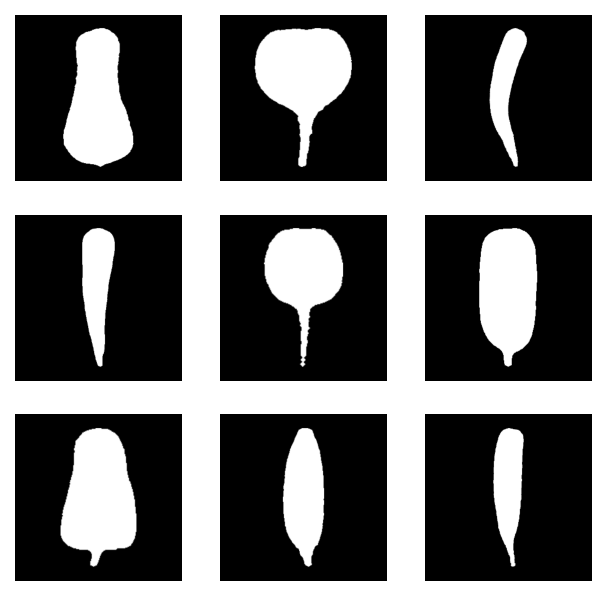

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting2(func,ts,cont,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0])
    return odds # 

In [8]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1T(tpara=[],mode=mode,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1(tpara=[],err_th=err_th,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

....................................................................................................
...................
CP 5.0, steps:118, etime: 114.12500 err: 4.9624985230
......................................................
CP 2.0, steps:172, etime: 164.92188 err: 1.9721212075
...........................
..............................E

[] [array([2.39238053, 2.80317983, 2.35396189])]


(0.9946022153842403, array([], dtype=int64))

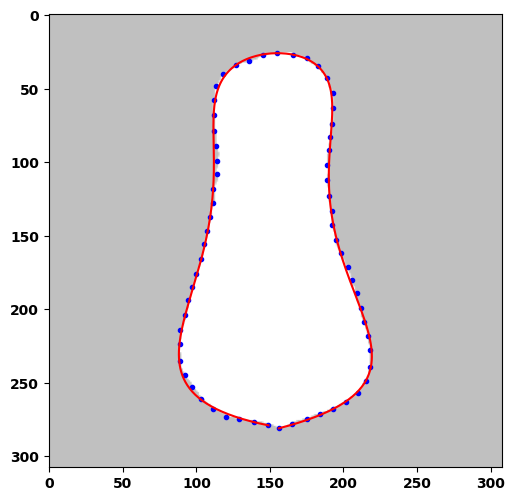

In [9]:
testOF1(imgn=0,N=7,err_th=1)

....................................................................................................
...................
CP 5.0, steps:118, etime: 115.96875 err: 4.9624985230
......................................................
CP 2.0, steps:172, etime: 167.21875 err: 1.9721212075
...........................
..............................
CP 1.0, steps:229, etime: 221.17188 err: 0.9946022154
......................................................................
..............................................................................E

[] [array([1.79170299, 1.94704454])]


(0.6499764370583019, array([], dtype=int64))

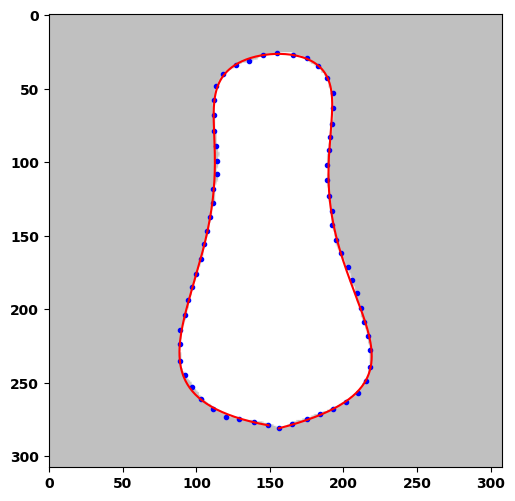

In [10]:
testOF1(imgn=0,N=7,err_th=0.65)

In [ ]:
testOF1(imgn=0,N=7,err_th=0.5)

In [ ]:
testOF1(imgn=1,N=9,err_th=1)

....
CP 5.0, steps:3, etime: 11.20312 err: 4.7721506974
................................................................................................
...................................................
CP 2.0, steps:150, etime: 249.26562 err: 1.9974661346
.................................................
....................................................................................................
..................................E

[] [array([2.79250568, 2.90461932])]


(0.9996290848960917, array([], dtype=int64))

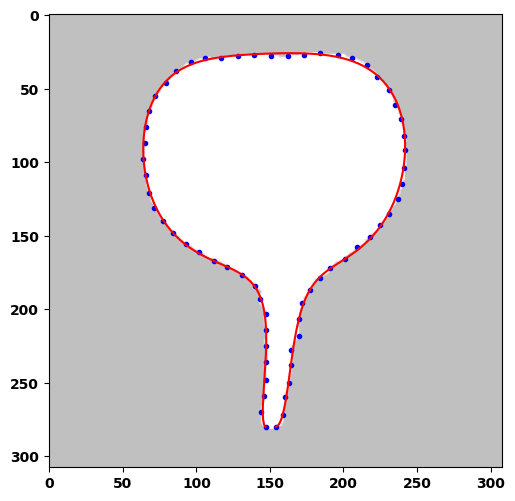

In [11]:
testOF1(imgn=1,N=10,err_th=1)

In [ ]:
testOF1(imgn=1,N=11,err_th=0.5)

...
CP 5.0, steps:2, etime: 10.00000 err: 4.8921059025
.................................................................................................
....................................
CP 2.0, steps:135, etime: 250.98438 err: 1.9940076990
......................^.........................................
....................................................................................................
........................
CP 1.0, steps:323, etime: 601.25000 err: 0.9979232242
............................................................................
....................................................................................................
................
CP 0.65, steps:515, etime: 957.40625 err: 0.6497642318
................................................................................^^..
......^^......^^....^^^.....^^^....^^^...^^^...^^^...^^^^...^^^^..^^^^..^^^^^..^^^^^...^^^^^....^^^^
^..........................................................................

In [ ]:
testOF1(imgn=2,N=8,err_th=1.0)

In [ ]:
testOF1(imgn=2,N=10,err_th=0.5)

In [ ]:
testOF1(imgn=2,N=11,err_th=0.5)

In [ ]:
testOF1(imgn=3,N=8,err_th=1)

In [ ]:
testOF1(imgn=3,N=9,err_th=0.5)

In [ ]:
testOF1(imgn=3,N=10,err_th=0.5)

In [ ]:
testOF1(imgn=4,N=10,err_th=1)

In [ ]:
testOF1(imgn=4,N=11,err_th=0.65)

In [ ]:
testOF1(imgn=4,N=12,err_th=0.5)

In [ ]:
testOF1(imgn=4,N=14,err_th=0.5)

In [ ]:
testOF1(imgn=5,N=8,err_th=1)

In [ ]:
testOF1(imgn=5,N=9,err_th=0.65)

In [ ]:
testOF1(imgn=6,N=11,err_th=1)

In [ ]:
testOF1(imgn=6,N=12,err_th=0.5)

In [ ]:
testOF1(imgn=7,N=6,err_th=1)

In [ ]:
testOF1(imgn=7,N=8,err_th=0.65)

In [ ]:
testOF1(imgn=8,N=8,err_th=1)

In [ ]:
testOF1(imgn=8,N=8,err_th=1)

In [ ]:
testOF1(imgn=8,N=8,err_th=1)

In [ ]:
testOF1(imgn=8,N=8,err_th=1)

In [ ]:
testOF1(imgn=8,N=9,err_th=0.5)